Симуляция для T_total = 0.20s...


  0%|          | 0/100 [00:00<?, ?it/s]

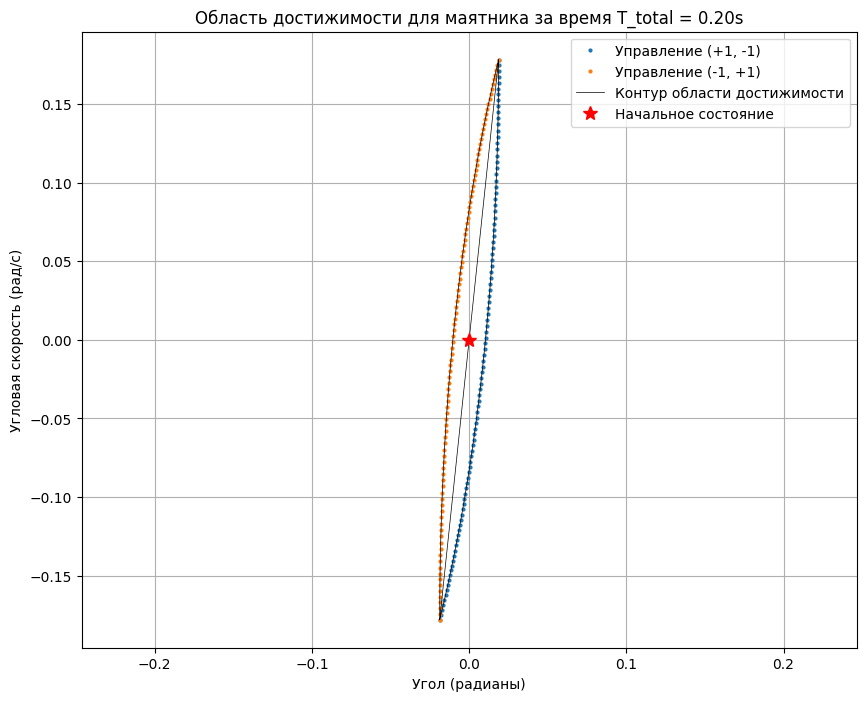

Симуляция для T_total = 1.00s...


  0%|          | 0/100 [00:00<?, ?it/s]

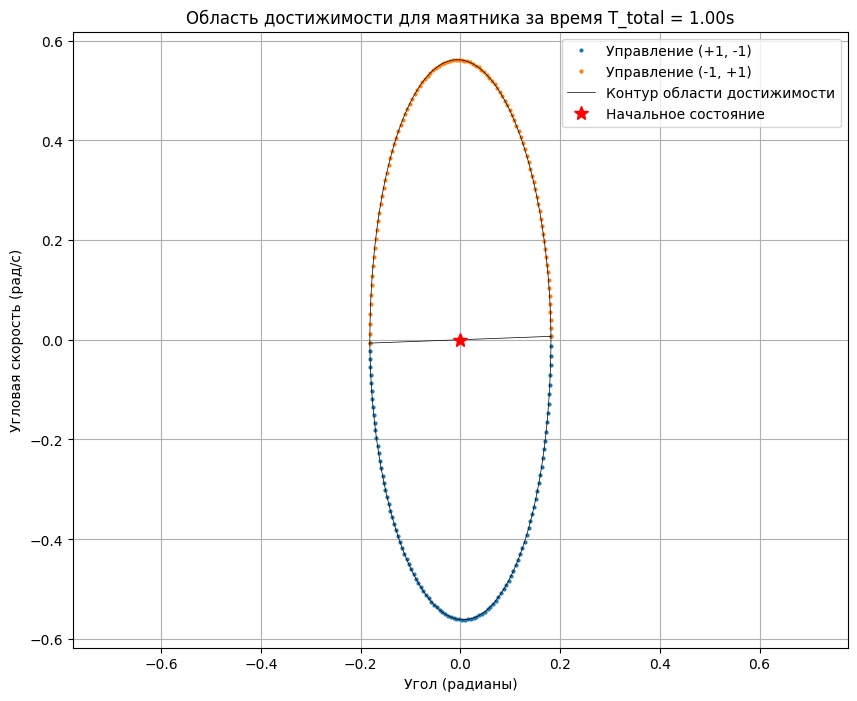

Симуляция для T_total = 2.00s...


  0%|          | 0/100 [00:00<?, ?it/s]

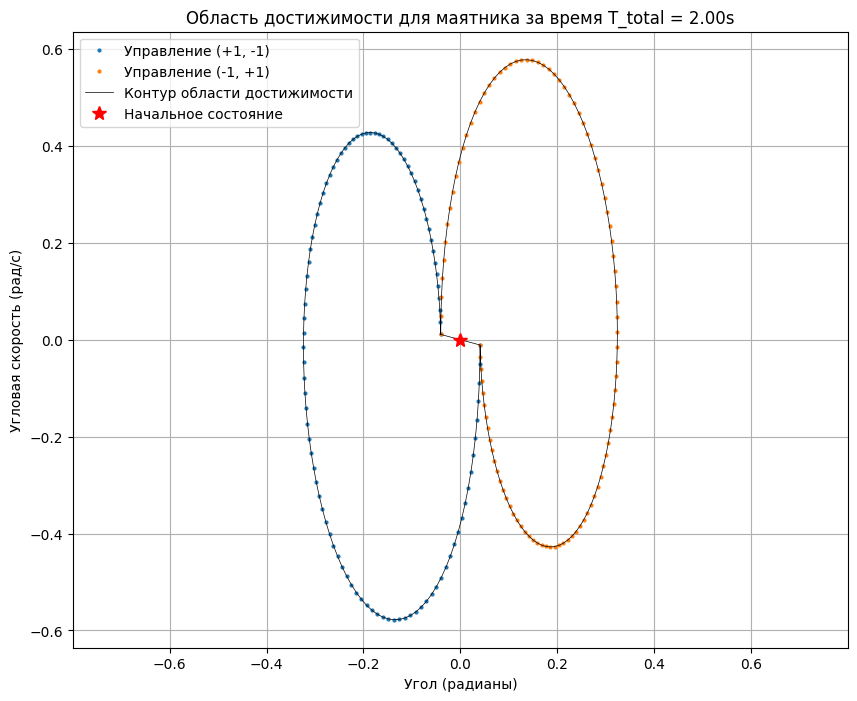

Симуляция для T_total = 4.00s...


  0%|          | 0/100 [00:00<?, ?it/s]

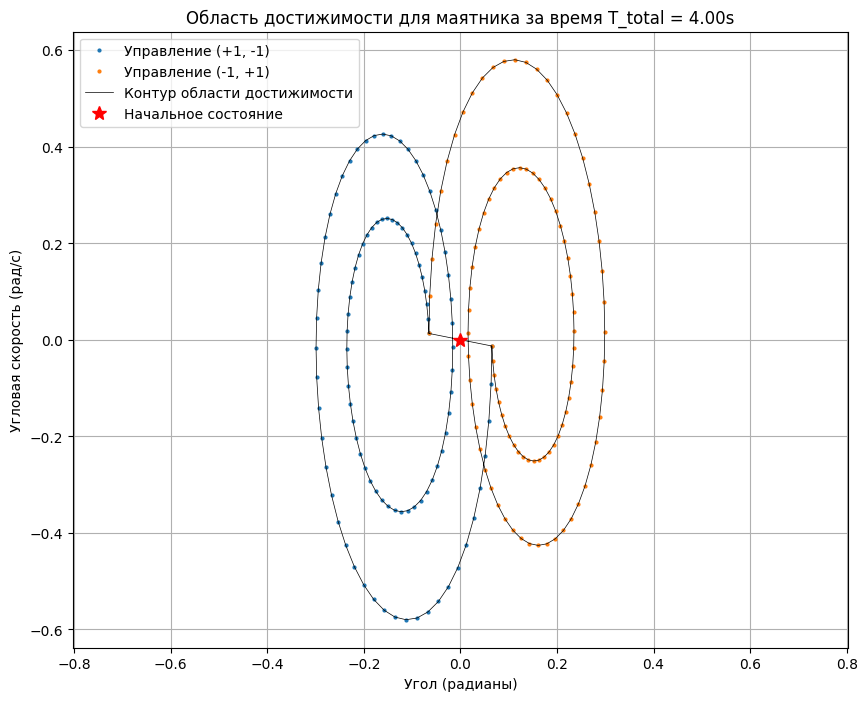

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm

# === 1. Определение параметров системы (маятник) ===
g = 9.81  # Ускорение свободного падения
L = 1.0   # Длина маятника
m = 1.0   # Масса маятника
b = 0.5   # Коэффициент демпфирования
u_max = 1.0 # Максимальный управляющий момент (торк)

# === 2. Функция динамики маятника ===
def pendulum_dynamics(t, y, u_val):
    """
    Система ОДУ для маятника.
    y = [theta, omega]
    """
    theta, omega = y
    dydt = [
        omega,
        -b * omega - (g / L) * np.sin(theta) + u_val
    ]
    return dydt

# === 3. Функция управления с переключением ===
def create_bang_bang_control(tau, u_sign1, u_sign2):
    """
    Создает функцию управления, которая переключается в момент t=tau.
    u(t) = u_sign1 * u_max на [0, tau]
    u(t) = u_sign2 * u_max на [tau, T_total]
    """
    def control_func(t):
        if t <= tau:
            return u_sign1 * u_max
        else:
            return u_sign2 * u_max
    return control_func

# === 4. Функция симуляции для произвольного tau и T_total ===
def simulate_pendulum(initial_state, T_total, tau, u_sign1, u_sign2):
    """
    Проводит симуляцию с заданным bang-bang управлением.
    """
    u_func = create_bang_bang_control(tau, u_sign1, u_sign2)
    
    # Решаем ОДУ в два этапа из-за разрыва в управляющей функции
    
    # Этап 1: от 0 до tau
    sol1 = solve_ivp(
        lambda t, y: pendulum_dynamics(t, y, u_func(t)),
        [0, tau],
        initial_state,
        dense_output=True
    )
    final_state1 = sol1.y[:, -1]
    
    # Этап 2: от tau до T_total
    sol2 = solve_ivp(
        lambda t, y: pendulum_dynamics(t, y, u_func(t)),
        [tau, T_total],
        final_state1,
        dense_output=True
    )
    final_state2 = sol2.y[:, -1]
    
    return final_state2

# === 5. Основная логика для построения области достижимости ===

def plot_reachable_set(T_total, num_tau_points=100):
    """
    Строит и визуализирует область достижимости.
    """
    initial_state = [0.0, 0.0]  # Начальное состояние (вертикально и неподвижно)
    
    tau_values = np.linspace(0, T_total, num_tau_points)
    
    # Списки для хранения конечных состояний
    boundary_points_1 = [] # для управления (+1, -1)
    boundary_points_2 = [] # для управления (-1, +1)
    
    print(f"Симуляция для T_total = {T_total:.2f}s...")
    
    # Перебираем все возможные tau
    for tau in tqdm(tau_values):
        # 1. Управление (+1, -1)
        final_state_1 = simulate_pendulum(initial_state, T_total, tau, 1, -1)
        boundary_points_1.append(final_state_1)
        
        # 2. Управление (-1, +1)
        final_state_2 = simulate_pendulum(initial_state, T_total, tau, -1, 1)
        boundary_points_2.append(final_state_2)
        
    boundary_points_1 = np.array(boundary_points_1)
    boundary_points_2 = np.array(boundary_points_2)
    
    # === Визуализация ===
    plt.figure(figsize=(10, 8))
    
    plt.plot(boundary_points_1[:, 0], boundary_points_1[:, 1], 'o', markersize=2, label='Управление (+1, -1)')
    plt.plot(boundary_points_2[:, 0], boundary_points_2[:, 1], 'o', markersize=2, label='Управление (-1, +1)')
    
    # Соединяем точки, чтобы получить контур
    all_points = np.vstack([boundary_points_1, np.flipud(boundary_points_2)])
    plt.plot(all_points[:, 0], all_points[:, 1], 'k-', linewidth=0.5, label='Контур области достижимости')
    
    plt.plot(initial_state[0], initial_state[1], 'r*', markersize=10, label='Начальное состояние')
    
    plt.title(f'Область достижимости для маятника за время T_total = {T_total:.2f}s')
    plt.xlabel('Угол (радианы)')
    plt.ylabel('Угловая скорость (рад/с)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# === Запуск симуляций для разных T_total ===
# dt из вашего вопроса здесь соответствует T_total/2
# Мы будем использовать T_total как общее время
dt_list = [0.1, 0.5, 1.0, 2.0]

for dt_val in dt_list:
    plot_reachable_set(T_total=2*dt_val, num_tau_points=100)

Симуляция для T=0.20s:   0%|          | 0/100 [00:00<?, ?it/s]

Симуляция для T=0.40s:   0%|          | 0/100 [00:00<?, ?it/s]

Симуляция для T=1.00s:   0%|          | 0/100 [00:00<?, ?it/s]

Симуляция для T=2.00s:   0%|          | 0/100 [00:00<?, ?it/s]

Симуляция для T=4.00s:   0%|          | 0/100 [00:00<?, ?it/s]

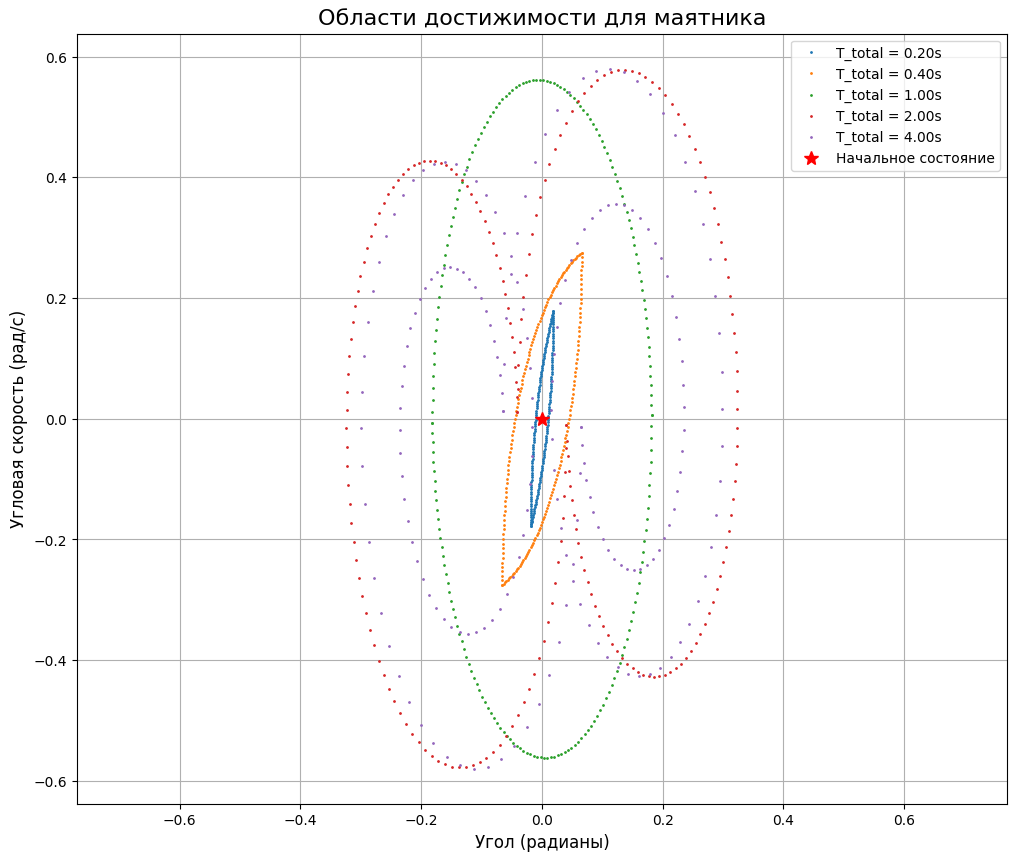

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm

# === 1. Определение параметров системы (маятник) ===
g = 9.81  # Ускорение свободного падения
L = 1.0   # Длина маятника
m = 1.0   # Масса маятника
b = 0.5   # Коэффициент демпфирования
u_max = 1.0 # Максимальный управляющий момент (торк)

# === 2. Функция динамики маятника ===
def pendulum_dynamics(t, y, u_val):
    """
    Система ОДУ для маятника.
    y = [theta, omega]
    """
    theta, omega = y
    dydt = [
        omega,
        -b * omega - (g / L) * np.sin(theta) + u_val
    ]
    return dydt

# === 3. Функция управления с переключением ===
def create_bang_bang_control(tau, u_sign1, u_sign2):
    """
    Создает функцию управления, которая переключается в момент t=tau.
    u(t) = u_sign1 * u_max на [0, tau]
    u(t) = u_sign2 * u_max на [tau, T_total]
    """
    def control_func(t):
        if t <= tau:
            return u_sign1 * u_max
        else:
            return u_sign2 * u_max
    return control_func

# === 4. Функция симуляции для произвольного tau и T_total ===
def simulate_pendulum(initial_state, T_total, tau, u_sign1, u_sign2):
    """
    Проводит симуляцию с заданным bang-bang управлением.
    """
    u_func = create_bang_bang_control(tau, u_sign1, u_sign2)
    
    # Решаем ОДУ в два этапа из-за разрыва в управляющей функции
    
    # Этап 1: от 0 до tau
    sol1 = solve_ivp(
        lambda t, y: pendulum_dynamics(t, y, u_func(t)),
        [0, tau],
        initial_state,
        dense_output=True
    )
    final_state1 = sol1.y[:, -1]
    
    # Этап 2: от tau до T_total
    sol2 = solve_ivp(
        lambda t, y: pendulum_dynamics(t, y, u_func(t)),
        [tau, T_total],
        final_state1,
        dense_output=True
    )
    final_state2 = sol2.y[:, -1]
    
    return final_state2

# === 5. Основная логика для построения области достижимости на одном графике ===

def plot_all_reachable_sets(dt_list, num_tau_points=100):
    """
    Строит и визуализирует области достижимости для разных dt на одном графике.
    """
    initial_state = [0.0, 0.0]  # Начальное состояние (вертикально и неподвижно)
    
    plt.figure(figsize=(12, 10))
    plt.title('Области достижимости для маятника', fontsize=16)
    plt.xlabel('Угол (радианы)', fontsize=12)
    plt.ylabel('Угловая скорость (рад/с)', fontsize=12)
    plt.grid(True)
    plt.axis('equal')
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(dt_list)))
    
    for i, dt_val in enumerate(dt_list):
        T_total = 2 * dt_val
        tau_values = np.linspace(0, T_total, num_tau_points)
        
        boundary_points = []
        
        # Перебираем все возможные tau
        for tau in tqdm(tau_values, desc=f'Симуляция для T={T_total:.2f}s'):
            # 1. Управление (+1, -1)
            final_state_1 = simulate_pendulum(initial_state, T_total, tau, 1, -1)
            boundary_points.append(final_state_1)
            
            # 2. Управление (-1, +1)
            final_state_2 = simulate_pendulum(initial_state, T_total, tau, -1, 1)
            boundary_points.append(final_state_2)
            
        boundary_points = np.array(boundary_points)
        
        # Наносим все точки на график
        label = f'T_total = {T_total:.2f}s'
        plt.plot(boundary_points[:, 0], boundary_points[:, 1], '.', markersize=2,  label=label)

    # Рисуем начальную точку в конце, чтобы она была поверх остальных
    plt.plot(initial_state[0], initial_state[1], 'r*', markersize=10, label='Начальное состояние')
    
    plt.legend()
    plt.show()

# === Запуск симуляций для разных T_total ===
# dt из вашего вопроса здесь соответствует T_total/2
# Давайте используем T_total = 2 * dt
dt_list = [0.1, 0.2, 0.5, 1.0, 2.0]

plot_all_reachable_sets(dt_list)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display

# === 1. Определение параметров системы (маятник) ===
g = 9.81  # Ускорение свободного падения
L = 1.0   # Длина маятника
m = 1.0   # Масса маятника
b = 0.5   # Коэффициент демпфирования
u_max = 1.0 # Максимальный управляющий момент (торк)

# === 2. Функция динамики маятника ===
def pendulum_dynamics(t, y, u_val):
    """
    Система ОДУ для маятника.
    y = [theta, omega]
    """
    theta, omega = y
    dydt = [
        omega,
        -b * omega - (g / L) * np.sin(theta) + u_val
    ]
    return dydt

# === 3. Функция управления с переключением ===
def create_bang_bang_control(tau, u_sign1, u_sign2):
    """
    Создает функцию управления, которая переключается в момент t=tau.
    u(t) = u_sign1 * u_max на [0, tau]
    u(t) = u_sign2 * u_max на [tau, T_total]
    """
    def control_func(t):
        if t <= tau:
            return u_sign1 * u_max
        else:
            return u_sign2 * u_max
    return control_func

# === 4. Функция симуляции для произвольного tau и T_total ===
def simulate_pendulum(initial_state, T_total, tau, u_sign1, u_sign2):
    """
    Проводит симуляцию с заданным bang-bang управлением.
    """
    u_func = create_bang_bang_control(tau, u_sign1, u_sign2)
    
    sol1 = solve_ivp(
        lambda t, y: pendulum_dynamics(t, y, u_func(t)),
        [0, tau],
        initial_state,
        dense_output=True
    )
    final_state1 = sol1.y[:, -1]
    
    sol2 = solve_ivp(
        lambda t, y: pendulum_dynamics(t, y, u_func(t)),
        [tau, T_total],
        final_state1,
        dense_output=True
    )
    final_state2 = sol2.y[:, -1]
    
    return final_state2

# ---

### Предварительный расчет всех областей достижимости

initial_state = [0.0, 0.0]
# Используем np.linspace для создания 10 точек от 0.1 до 4.0
dt_list = np.linspace(0.1, 0.7, 30)
num_tau_points = 300
reachable_sets_data = {}

print("Проводим предварительный расчет всех областей достижимости...")

for dt_val in dt_list:
    T_total = 2 * dt_val
    tau_values = np.linspace(0, T_total, num_tau_points)
    
    boundary_points = []
    
    for tau in tqdm(tau_values, desc=f'Расчет для T={T_total:.2f}s'):
        final_state_1 = simulate_pendulum(initial_state, T_total, tau, 1, -1)
        boundary_points.append(final_state_1)
        
        final_state_2 = simulate_pendulum(initial_state, T_total, tau, -1, 1)
        boundary_points.append(final_state_2)
    
    # Сохраняем данные в словарь, используя T_total как ключ
    key = f'T={T_total:.2f}'
    reachable_sets_data[key] = np.array(boundary_points)
    
print("Расчет завершен!")

Проводим предварительный расчет всех областей достижимости...


Расчет для T=0.20s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=0.24s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=0.28s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=0.32s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=0.37s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=0.41s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=0.45s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=0.49s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=0.53s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=0.57s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=0.61s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=0.66s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=0.70s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=0.74s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=0.78s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=0.82s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=0.86s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=0.90s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=0.94s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=0.99s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=1.03s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=1.07s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=1.11s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=1.15s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=1.19s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=1.23s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=1.28s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=1.32s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=1.36s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет для T=1.40s:   0%|          | 0/300 [00:00<?, ?it/s]

Расчет завершен!


In [ ]:
# ---

### Создание интерактивного графика

# Создаем виджеты-флажки (checkboxes) на основе ключей из `reachable_sets_data`
checkboxes = {
    key: widgets.Checkbox(value=True, description=f'T_total = {key.split("=")[1]}s')
    for key in reachable_sets_data.keys()
}

def update_plot(**kwargs):
    """
    Функция, которая обновляет график на основе выбранных dt.
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title('Области достижимости для маятника', fontsize=16)
    ax.set_xlabel('Угол (радианы)', fontsize=12)
    ax.set_ylabel('Угловая скорость (рад/с)', fontsize=12)
    ax.grid(True)
    ax.axis('equal')
    
    # Создаем палитру цветов
    colors = plt.cm.viridis(np.linspace(0, 1, len(reachable_sets_data)))
    
    for i, key in enumerate(reachable_sets_data.keys()):
        # Проверяем, включен ли соответствующий виджет
        if kwargs[key]:
            data = reachable_sets_data[key]
            ax.plot(data[:, 0], data[:, 1], '.', markersize=2,  label=f'T_total = {key.split("=")[1]}s')
    
    ax.plot(initial_state[0], initial_state[1], 'r*', markersize=10, label='Начальное состояние')
    ax.legend()
    plt.show()

# Используем `widgets.interactive` для связывания виджетов с функцией
interactive_plot = widgets.interactive(
    update_plot,
    **checkboxes
)

# Отображаем виджеты и график
display(interactive_plot)

interactive(children=(Checkbox(value=True, description='T_total = 0.20s'), Checkbox(value=True, description='T…

In [8]:

def update_plot(T_total_0_2=True, T_total_0_4=True, T_total_1_0=True, T_total_2_0=True, T_total_4_0=True):
    """
    Функция, которая обновляет график на основе выбранных dt.
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title('Области достижимости для маятника', fontsize=16)
    ax.set_xlabel('Угол (радианы)', fontsize=12)
    ax.set_ylabel('Угловая скорость (рад/с)', fontsize=12)
    ax.grid(True)
    ax.axis('equal')
    
    # Словарь для удобства сопоставления виджетов и данных
    visibility_map = {
        'T=0.20': T_total_0_2,
        'T=0.40': T_total_0_4,
        'T=1.00': T_total_1_0,
        'T=2.00': T_total_2_0,
        'T=4.00': T_total_4_0
    }
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(dt_list)))
    
    for i, key in enumerate(reachable_sets_data.keys()):
        if visibility_map[key]:
            data = reachable_sets_data[key]
            ax.plot(data[:, 0], data[:, 1], '.', markersize=2, color=colors[i], label=f'T_total = {key.split("=")[1]}s')
    
    ax.plot(initial_state[0], initial_state[1], 'r*', markersize=10, label='Начальное состояние')
    ax.legend()
    plt.show()

# Создаем виджеты-флажки (checkboxes) для каждого T_total
dt_values_for_widgets = {
    'T_total_0_2': widgets.Checkbox(value=True, description='T_total = 0.20s'),
    'T_total_0_4': widgets.Checkbox(value=True, description='T_total = 0.40s'),
    'T_total_1_0': widgets.Checkbox(value=True, description='T_total = 1.00s'),
    'T_total_2_0': widgets.Checkbox(value=True, description='T_total = 2.00s'),
    'T_total_4_0': widgets.Checkbox(value=True, description='T_total = 4.00s')
}

# Используем `widgets.interactive` для связывания виджетов с функцией
interactive_plot = widgets.interactive(
    update_plot,
    **dt_values_for_widgets
)

# Отображаем виджеты и график
display(interactive_plot)

interactive(children=(Checkbox(value=True, description='T_total = 0.20s'), Checkbox(value=True, description='T…